# Load and Evaluate a trained model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix as sk_confusion_matrix 
from IPython.display import display

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Loading

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, classification=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.classification = classification
        bins = [18, 28, 40]
       # Add a 'label' column to the DataFrame
        if self.classification:
            self.data['label'] = self.data['real_age'].apply(
                lambda age: 0 if age <= bins[0] else 
                            1 if age <= bins[1] else 
                            2 if age <= bins[2] else 
                            3
            )

            self.classes = self.data['label'].unique().tolist()
        else:
            self.data['label'] = self.data['real_age']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to(device)
        image = image.float() / image.max() # 255.0 # try normalising by max value in image
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1)),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_csv = 'appa-real-release/cropped_train.csv'
val_csv = 'appa-real-release/cropped_valid.csv'
test_csv = 'appa-real-release/cropped_test.csv'

train_dir = 'appa-real-release/cropped_train'
val_dir = 'appa-real-release/cropped_valid'
test_dir = 'appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms)

In [5]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

print(f"Classes: {train_dataset.classes}.")

Train Dataset Size: 3920
Val Dataset Size: 1438
Test Dataset Size: 1828
Classes: [0, 3, 1, 2].


In [6]:
# Compute class weights
class_counts = train_dataset.data['label'].value_counts()
print(f"Class counts: \n{class_counts}\n")
class_weights = 1.0 / class_counts
print(f"Class weights: \n{class_weights}\n")
sample_weights = train_dataset.data['label'].map(class_weights)
print(f"Sample weights: \n{sample_weights}\n")

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class counts: 
label
1    1167
2     971
3     934
0     848
Name: count, dtype: int64

Class weights: 
label
1    0.000857
2    0.001030
3    0.001071
0    0.001179
Name: count, dtype: float64

Sample weights: 
0       0.001179
1       0.001179
2       0.001071
3       0.001071
4       0.001179
          ...   
3915    0.001071
3916    0.001071
3917    0.001030
3918    0.000857
3919    0.000857
Name: label, Length: 3920, dtype: float64



In [7]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    sampler=sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

## Load Model for Evaluation

In [20]:
# Change to apropriate model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

if num_features == 512:
    resnet_arch = 'ResNet18'
elif num_features ==2048:
    resnet_arch = 'ResNet50'
else:
    resnet_arch = 'other'
    
# Add a fully connected linear layer which transforms from 512 nodes -> 1 node
# Note that we dont add a sigmoid activation function here because we use nn.BCEWithLogitsLoss(), which applies sigmoid while calculating loss
model.fc = nn.Linear(num_features, 4)

for param in model.fc.parameters():
    param.requires_grad = True

Number of features from pre-trained model 512


In [21]:
print(f"Number of Learnable/Learned Parameters:  {sum([param.numel() for param in model.layer4.parameters() if param.requires_grad==True]) + sum([param.numel() for param in model.fc.parameters()])}")

Number of Learnable/Learned Parameters:  8395780


In [24]:
saved_model_path = './models/multiclass/ResNet18_GradualUnfreeze_2025-02-06_v1.pth'
model.load_state_dict(torch.load(saved_model_path, weights_only=True))

# If you saved the model on a GPU and are loading it on a CPU, you can specify:
# model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Evaluate Model

In [11]:
%reload_ext tensorboard
%tensorboard --logdir=./logs/ --host localhost --port 6011

Reusing TensorBoard on port 6011 (pid 13544), started 9 days, 19:16:41 ago. (Use '!kill 13544' to kill it.)

### Test Metrics
- Loss, Accuracy, Precision, Recall, F1-Score

In [25]:
def test(model, device, test_loader, criterion, num_classes=4):
    model.eval()  # Set model to evaluation mode
    
    test_loss = 0
    correct = 0
    all_targets = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Compute loss
            output = model(data)  # Output is logits       
            test_loss += criterion(output, target).item()  # Sum up batch loss
            
            # Get probabilities using softmax for multiclass
            probs = torch.softmax(output, dim=1)
            
            # Get predictions (class with highest probability)
            pred = torch.argmax(probs, dim=1)
            
            # Convert to numpy for sklearn metrics
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Update correct count
            correct += pred.eq(target).sum().item()
    
    # Average the test loss over the entire dataset
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    # Compute multiclass metrics
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    
    # Confusion matrix
    conf_matrix = sk_confusion_matrix(all_targets, all_preds)
    
    return (
        test_loss, 
        test_accuracy, 
        precision, 
        recall, 
        f1, 
        conf_matrix, 
    )

In [26]:
criterion = nn.CrossEntropyLoss()

loss, accuracy, precision, recall, f1, conf_matrix = test(model, device, val_loader, criterion)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Normalise by total (show % of all predictions)
#conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum()
# Normalise by row
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

conf_matrix_df = pd.DataFrame(
    conf_matrix_normalized,
    columns=[f'Pred {i}' for i in range(4)],
    index=[f'Act {i}' for i in range(4)]
)
display(conf_matrix_df.round(2))

Loss: 1.4260, Accuracy: 58.2754, Precision: 0.5770, Recall: 0.5880, F1-Score: 0.5770


,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.73,0.19,0.04,0.04
Act 1,0.23,0.57,0.15,0.05
Act 2,0.09,0.36,0.32,0.23
Act 3,0.05,0.09,0.13,0.73


### Test Predictions with Confidence

In [72]:
def visualize_model(model, num_images=6, show_fails=False, high_conf=False):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get probabilities using softmax
            probs = torch.softmax(output, dim=1)
            
            # Get predictions (class with highest probability)
            pred = torch.argmax(probs, dim=1)

            for j in range(inputs.size()[0]):
                # Check if prediction matches the label
                is_misclassified = pred[j].item() != labels[j].item()

                # Skip correctly classified cases if show_fails is True
                if show_fails and not is_misclassified:
                    continue

                # Get confidence in predicted class
                confidence = probs[j][pred[j].item()].item()
                # Skip predictions in the range 0.25-0.75
                #if high_conf and not (confidence <0.3 or confidence>0.7):
                #    continue
                    
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {pred[j].item()}. Ground Truth: {labels[j].item()}.')
                print(f'Top-1 Probability: {confidence:.3f}')
                print(f'Class probabilities: {probs[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = vutils.make_grid(inp)  
    inp = inp.permute(1, 2, 0) 
    
    # Convert mean and std to PyTorch tensors
    mean = torch.tensor([0.485, 0.456, 0.406], device=inp.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inp.device)
    
    # Normalize the image
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)  # Ensure values are within [0, 1]
    
    # Convert the tensor to a NumPy array for visualization
    inp = inp.cpu().numpy()

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

0/1 - High confidence, ~0.5 - Low confidence
Top-1 Probability: 0.407
Class probabilities: tensor([0.1523, 0.1539, 0.2864, 0.4074], device='cuda:0')


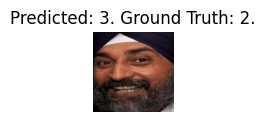

Top-1 Probability: 0.296
Class probabilities: tensor([0.2958, 0.2646, 0.2688, 0.1708], device='cuda:0')


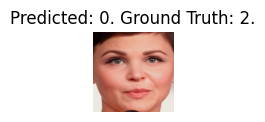

Top-1 Probability: 0.365
Class probabilities: tensor([0.2515, 0.3653, 0.2317, 0.1516], device='cuda:0')


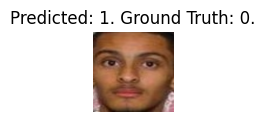

Top-1 Probability: 0.378
Class probabilities: tensor([0.1570, 0.1854, 0.2798, 0.3778], device='cuda:0')


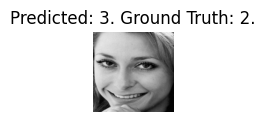

Top-1 Probability: 0.366
Class probabilities: tensor([0.1491, 0.2098, 0.2753, 0.3658], device='cuda:0')


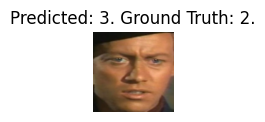

Top-1 Probability: 0.369
Class probabilities: tensor([0.1922, 0.3691, 0.2616, 0.1771], device='cuda:0')


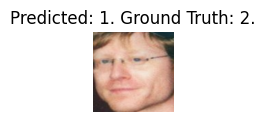

Top-1 Probability: 0.355
Class probabilities: tensor([0.1852, 0.3549, 0.3184, 0.1415], device='cuda:0')


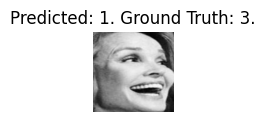

Top-1 Probability: 0.356
Class probabilities: tensor([0.1501, 0.3341, 0.3562, 0.1596], device='cuda:0')


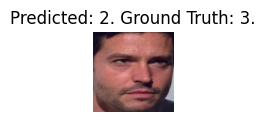

In [76]:
print('0/1 - High confidence, ~0.5 - Low confidence')
print('='*50)
visualize_model(model, num_images=8, show_fails=True, high_conf=True)

# Comparison

In [15]:
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, message=".*torch.load.*")

models_dir = './models/multiclass'
results = []

for ix, filename in enumerate(os.listdir(models_dir)):
    model_path = os.path.join(models_dir, filename)
    if filename.endswith(".pth"):
        # Load the model
        # First make sure the architecture matches
        if 'ResNet18' in model_path:
            model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
            num_features = model.fc.in_features
        else:
            model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            num_features = model.fc.in_features
    
        model.fc = nn.Linear(num_features, 4)
    
        # Now we can load the same model
        state_dict = torch.load(model_path, weights_only=True)
        model.load_state_dict(state_dict) # Load the weights into the model
        model.to(device)
        model.eval()
    
        loss, accuracy, precision, recall, f1, conf_matrix = test(model, device, val_loader, criterion)
    
        tn, fp, fn, tp = conf_matrix 
        
        results.append({
            'model': filename,
            'loss': round(loss,3),
            'accuracy': round(accuracy,3),
            'precision': round(precision,3),
            'recall': round(recall,3),
            'f1-score': round(f1,3),
            'conf_matrix': conf_matrix
        })
    
        print(f"{(100. * ((ix+1) / len(os.listdir(models_dir)))):.2f}%")


results_df = pd.DataFrame(results)

20.00%
40.00%
60.00%
80.00%
100.00%


## Accuracy, Precision, Recall, F1-Score, ROC-AUC

- **Recall / True Positive Rate**
    - $\ \frac{TP}{TP + FN}$
    - Proportion of actual positives which were classified as positive
- **False Positive Rate**
    - $\ \frac{FP}{FP+TN} $
    - Proportion of all actual negatives which were classified as positive
- **Precision**
    - $\ \frac{TP}{TP + FP}$
    - Proportion of positive classification which were actually positive
- **F1-Score**
    - $\ 2\frac{Precision \cdot Recall}{Precision + Recall} = \frac{2TP}{2TP + FP + FN}$
    - Harmonic mean of precision and recall
- **ROC-AUC**
    - Represents the probability that the model, given a random positive and negative sample, ranks the positive higher than the negative
 
Note: Class 0 is negative. Class 1 is positive

In [16]:
sorted_results = results_df.sort_values(by='f1-score', ascending=False).drop(index=[])
# Show results, hiding confusion matrix values
display(sorted_results.drop(columns=['loss', 'conf_matrix']))

,model,accuracy,precision,recall,f1-score
2,ResNet18_GradualUnfreeze_2025-02-06_v1.pth,58.275,0.577,0.588,0.577
3,ResNet50_fc+layer4_2025-02-05_v1.pth,53.268,0.527,0.539,0.531
0,ResNet18_fc+layer4_2025-02-05_v1.pth,52.712,0.581,0.513,0.521
4,ResNet50_fc_2025-01-30_v1.pth,48.470,0.485,0.492,0.487
1,ResNet18_fc_2025-02-05_v1.pth,47.010,0.465,0.469,0.464


## Confusion Matrices

In [17]:
for index, row in sorted_results.iterrows():
    # Normalise by total (show % of all predictions)
    #conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum()
    # Normalise by row
    model_name = row['model']
    conf_matrix = row['conf_matrix']
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    conf_matrix_df = pd.DataFrame(
        conf_matrix_normalized,
        columns=[f'Pred {i}' for i in range(4)],
        index=[f'Act {i}' for i in range(4)]
    )
    print(f"\n{model_name}:\n")
    display(conf_matrix_df.round(2))


ResNet18_GradualUnfreeze_2025-02-06_v1.pth:



,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.73,0.19,0.04,0.04
Act 1,0.23,0.57,0.15,0.05
Act 2,0.09,0.36,0.32,0.23
Act 3,0.05,0.09,0.13,0.73



ResNet50_fc+layer4_2025-02-05_v1.pth:



,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.63,0.21,0.09,0.07
Act 1,0.24,0.47,0.21,0.09
Act 2,0.10,0.35,0.33,0.22
Act 3,0.05,0.09,0.13,0.73



ResNet18_fc+layer4_2025-02-05_v1.pth:



,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.44,0.48,0.05,0.03
Act 1,0.07,0.76,0.13,0.04
Act 2,0.03,0.57,0.28,0.12
Act 3,0.02,0.19,0.22,0.57



ResNet50_fc_2025-01-30_v1.pth:



,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.55,0.23,0.15,0.07
Act 1,0.26,0.40,0.24,0.10
Act 2,0.14,0.28,0.38,0.20
Act 3,0.09,0.10,0.18,0.63



ResNet18_fc_2025-02-05_v1.pth:



,Pred 0,Pred 1,Pred 2,Pred 3
Act 0,0.43,0.35,0.12,0.10
Act 1,0.18,0.49,0.18,0.15
Act 2,0.12,0.28,0.32,0.28
Act 3,0.09,0.12,0.16,0.64
